# Imports #

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install mtcnn
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.manifold import TSNE
from PIL import Image
from skimage import exposure
from mtcnn import MTCNN
from collections import defaultdict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.2 MB/s eta 0:00:00


In [2]:
current_path = '/content/drive/MyDrive/Colab Notebooks/FacialClustering'

# PreProcess #

## Image Normalization PreProcess ##

In [41]:
def load_and_preprocess_images(dataset_path, save_path):
    # Create the save path directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    # Iterate through the dataset directory
    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            # Load the image using PIL
            image = Image.open(file_path)
            # Convert the image to grayscale
            image = image.convert('L')  # Convert to grayscale
            # Normalize the pixel values to the range [0, 1]
            image = np.array(image) / 255.0

            # Save the preprocessed image without extension
            save_file_path = os.path.join(save_path, file_name + '.png')  # Save with original file name
            Image.fromarray((image * 255).astype(np.uint8)).save(save_file_path)  # Save as image
            # Store the preprocessed image path and its label
            preprocessed_images.append(save_file_path)
            labels.append(file_name)  # Use original file name as label

    return preprocessed_images, labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/NormalizedDataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")

1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 169ms/step
[{'box': [119, 83, 111, 138], 'confidence': 0.9999492168426514, 'keypoints': {'left_eye': (151, 134), 'right_eye': (203, 134), 'nose': (178, 166), 'mouth_left': (157, 191), 'mouth_right': (200, 191)}}]
1/1 [==============================] - 0s 27ms/step
[{'box': [103, 80, 112, 143], 'confidence': 0.9999380111694336, 'keypoints': {'left_eye': (137, 136), 'right_eye': (188, 135), 'nose': (163, 172), 'mouth_left': (138, 187), 'mouth_right': (188, 187)}}]
1/1 [==============================] - 0s 31ms/step
[{'box': [122, 64, 119, 154], 'confidence': 0.9999986886978149, 'keypoints': {'left_eye': (153, 118), 'right_eye': (207, 122), 'nose': (177, 151), 'mouth_left': (155, 175), 'mouth_right': (205, 178)}}]
1/1 [==============================] - 0s 33ms/step
[{'box': [119, 61, 125, 164], 'confidence': 0.9999946355819702, 'keypoints': {'left_eye': (155, 117), 'right_eye': (210, 118), 'nose': (185, 144), 'mouth_left': (161, 182), 'mouth_right

## Normalization, Face Detection, Crop & Resize, Data Balancing ##

In [ ]:
def load_and_preprocess_images(dataset_path, save_path, target_size=(224, 224)):
    # Create the save path directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    # Initialize face detector
    detector = MTCNN()
    # Dictionary to keep track of the number of images per label
    label_count = defaultdict(int)

    # Iterate through the dataset directory
    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            # Load the image using PIL
            image = Image.open(file_path)

            # Check if the image is grayscale, convert it to RGB if necessary
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Face detection and alignment
            faces = detector.detect_faces(np.array(image))

            print(faces)
            if len(faces) != 1:  # Skip images with no or multiple faces detected
                continue
            x, y, w, h = faces[0]['box']
            # Crop and resize the face region
            face_image = image.crop((x, y, x + w, y + h)).resize(target_size)

            # Convert the image to grayscale
            face_array = np.array(face_image.convert('L'))
            # Perform histogram equalization for contrast enhancement
            face_array = exposure.equalize_hist(face_array)

            # Normalize the pixel values to the range [0, 1]
            face_array = face_array / 255.0

            # Save the preprocessed image without extension
            save_file_path = os.path.join(save_path, file_name + '.png')  # Save with original file name
            Image.fromarray((face_array * 255).astype(np.uint8)).save(save_file_path)  # Save as image

            # Store the preprocessed image path and its label
            preprocessed_images.append(save_file_path)
            labels.append(file_name)  # Use original file name as label

            # Update label count
            label_count[file_name] += 1

    # Ensure data balancing
    min_count = min(label_count.values())
    balanced_preprocessed_images = []
    balanced_labels = []
    for img_path, label in zip(preprocessed_images, labels):
        if label_count[label] > min_count:
            balanced_preprocessed_images.append(img_path)
            balanced_labels.append(label)
            label_count[label] -= 1

    return balanced_preprocessed_images, balanced_labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/NormalizedDataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")

# Feature Extraction Methods #

## NP Feature Extraction ##

In [24]:
# Load the Dataset
data_path = f'{current_path}/dataset/NormalizedDataset'
image_files = []
labels = []

for file_name in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, file_name)):
        image_files.append(os.path.join(data_path, file_name))
        labels.append(file_name)

# Feature Extraction
def extract_feature(image):
    # Apply any preprocessing if needed
    # Extract features using a pre-trained CNN or any other method
    # Placeholder function, replace with actual feature extraction
    feature_vector = np.random.rand(1000)  # Random feature vector, replace with actual features
    return feature_vector

feature_vectors = []
for image_file in image_files:
    image = cv2.imread(image_file)
    feature_vector = extract_feature(image)
    feature_vectors.append(feature_vector)

print('number of labels', len(labels))

# # Print features and labels
# for i in range(len(labels)):
#     print("Label:", labels[i])
#     print("Feature Vector:", feature_vectors[i])

# Saving Feature Vectors (optional)
np.save(f'{current_path}/feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/labels.npy', labels)

number of labels 175


## VGG16 Feature Extraction ##

In [42]:
# Load the Dataset
data_path = f'{current_path}/dataset/NormalizedDataset'
# data_path = f'{current_path}/dataset/dataset'
image_files = []
labels = []

for file_name in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, file_name)):
        image_files.append(os.path.join(data_path, file_name))
        labels.append(file_name)

# Feature Extraction using a pre-trained CNN (VGG16)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_feature(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    features = vgg16.predict(img_array)
    return features.flatten()

feature_vectors = []
for image_file in image_files:
    feature_vector = extract_feature(image_file)
    feature_vectors.append(feature_vector)

# Saving Feature Vectors
np.save(f'{current_path}/feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/labels.npy', labels)

1/1 [==============================] - 1s 919ms/step


# Dimension Reduction Methods #

## PCA Dimension Reduction ##

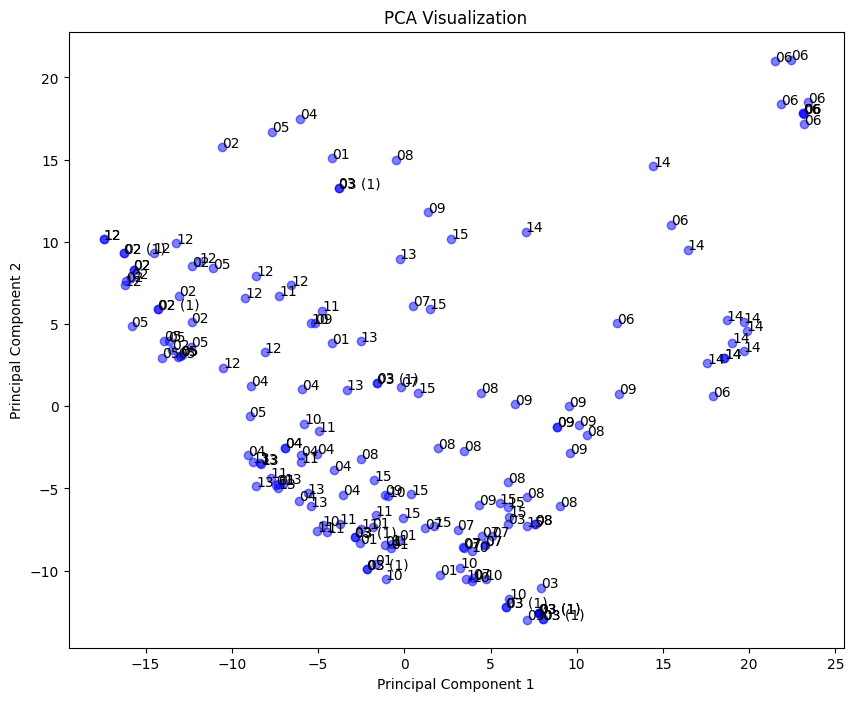

In [50]:
# Dimension Reduction
pca = PCA(n_components=175)  # You can choose the number of components based on your dataset
reduced_features = pca.fit_transform(feature_vectors)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.5)
for i in range(len(labels)):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], labels[i].split('.')[0].split('subject')[1])
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## TSNE Dimension Reduction ##

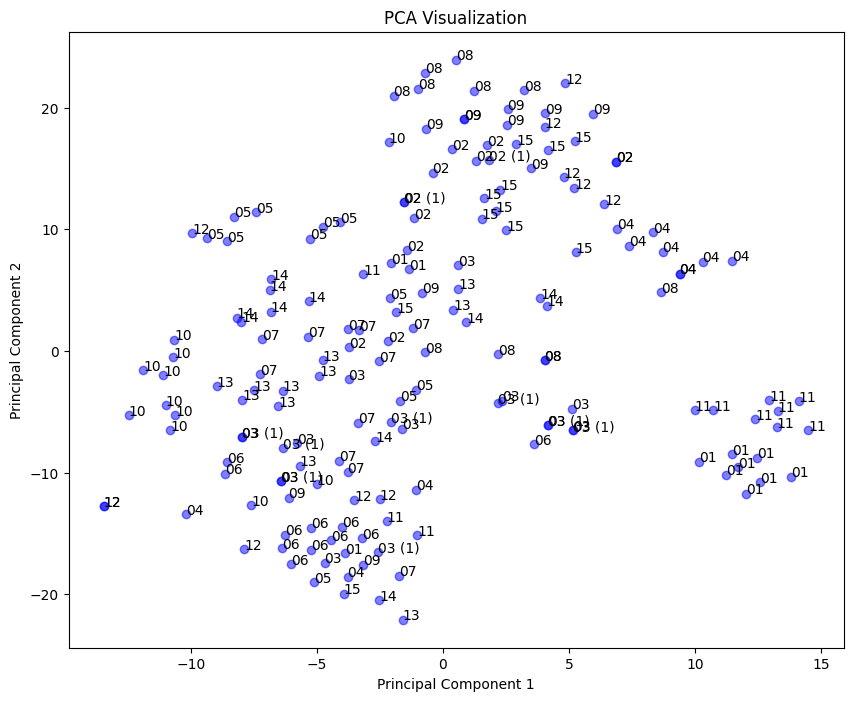

In [43]:
# Dimension Reduction using t-SNE
# Convert feature_vectors to a NumPy array
feature_vectors_array = np.array(feature_vectors)

# Dimension Reduction using t-SNE
tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(feature_vectors_array)
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.5)
for i in range(len(labels)):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], labels[i].split('.')[0].split('subject')[1])
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Clustering Methods #

## Kmeans Clustering  ##

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


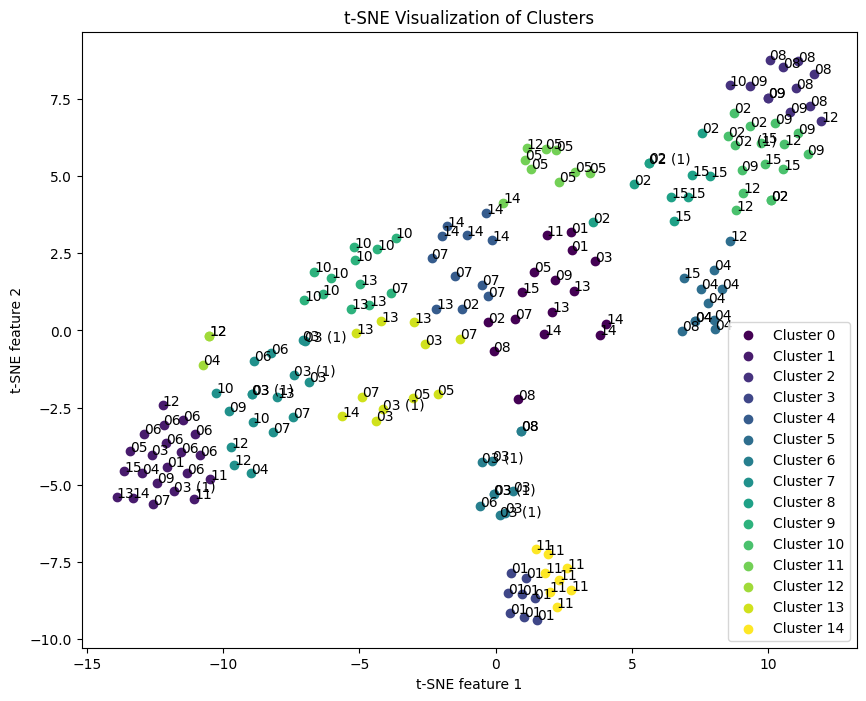

In [46]:
# Clustering
kmeans = KMeans(n_clusters=15)  # You can choose the number of clusters based on your dataset
clusters = kmeans.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

## DBSCAN Clustering  ##

11


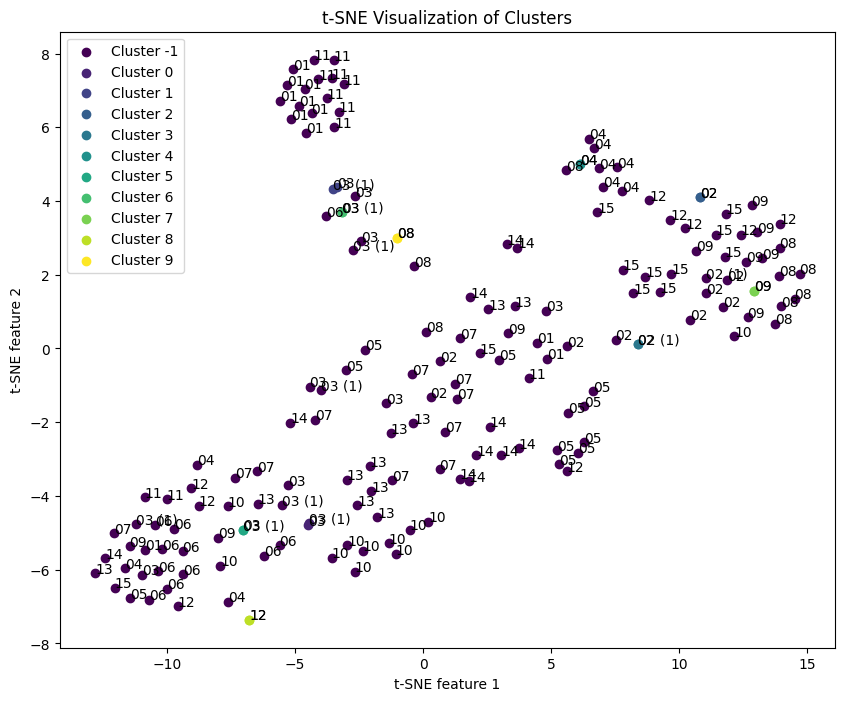

In [45]:
# Clustering
dbscan = DBSCAN(eps=0.1, min_samples=2)  # Adjust parameters as needed
clusters = dbscan.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)
print(len(unique_clusters))

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()
